In [1]:
%pylab inline
%load_ext autoreload
%autoreload 1
sys.path.append('./src')

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import division
%aimport psearch

In [3]:
from psearch import *

In [4]:
import math as mt
import numpy as np
import pandas as pd
import seaborn as sb
import pyfits as pf
import matplotlib.pyplot as plt
from IPython.display import clear_output

from glob import glob
from copy import copy
from os.path import join, basename, abspath

from numpy.core.records import array as rarr
from numpy.lib.recfunctions import stack_arrays, merge_arrays

In [5]:
sb.set_style('white')
sb.set_context('paper')
rc('figure', figsize=(14,5), dpi=100)
pd.set_option('precision', 3)

In [6]:
files = sorted(glob('../../../../analysis/k2_05/injection_tests/data/reduced/EPIC_*.fits'))
epics = array(map(lambda fn:int(basename(fn).split('_')[1]), files))

In [7]:
results = {}

In [8]:
Y = [1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
     0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
     0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
     1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
     0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
     1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
     0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
     1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
     1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
     1, 1, 0, 1, 1, 0, 1, 0, 0, 1]

In [21]:
tm = MA(supersampling=10, nldc = 0)

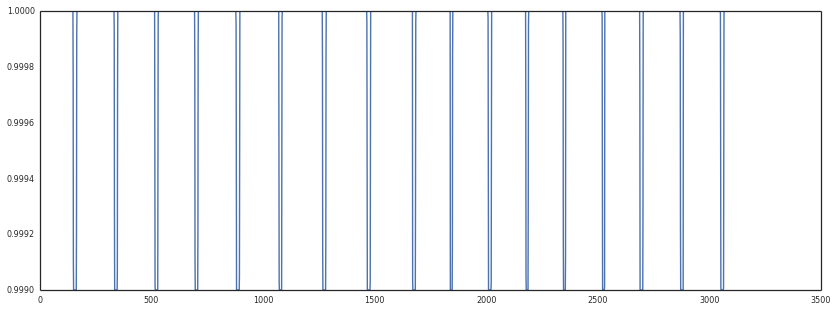

In [32]:
k = 0.1
k2 = k**2
f = 0.1

flux_e = (k2+tm.evaluate(ts.time, k, [], 0, 4.4, 4.6, 0.5*pi, e=0, w=0)-1.)/k2
plot((1+flux_e*k2*f)/(1+k2*f))

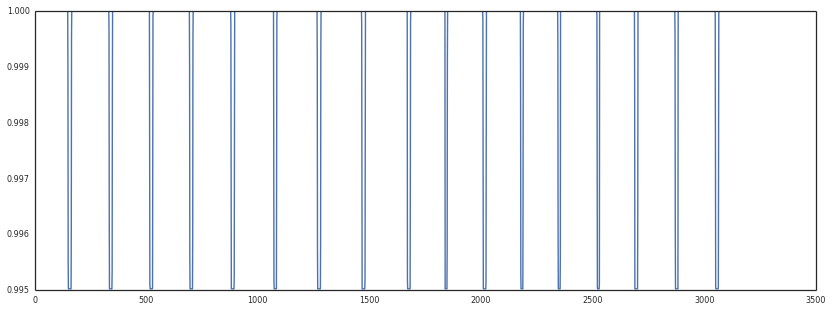

In [35]:
k = 0.1
k2 = k**2
f = 0.5

flux_e = tm.evaluate(ts.time, k, [], 0, 4.4, 4.6, 0.5*pi, e=0, w=0)
plot(1 + f*(flux_e-1)/(1+f*k2))

In [12]:
ts._pv_trf

array([  5.61061561e+00,   2.31214467e+03,   1.35155911e-01,
         1.37977944e+01,   2.66316510e-01])

5.61394053714 5.61072075967 0.135033589448 0.0182340702793 

lnlike 0: -11398483.01
lnlike 1:   12013.97
lnlike 2: -11391827.70
lnlike 3:   16147.80


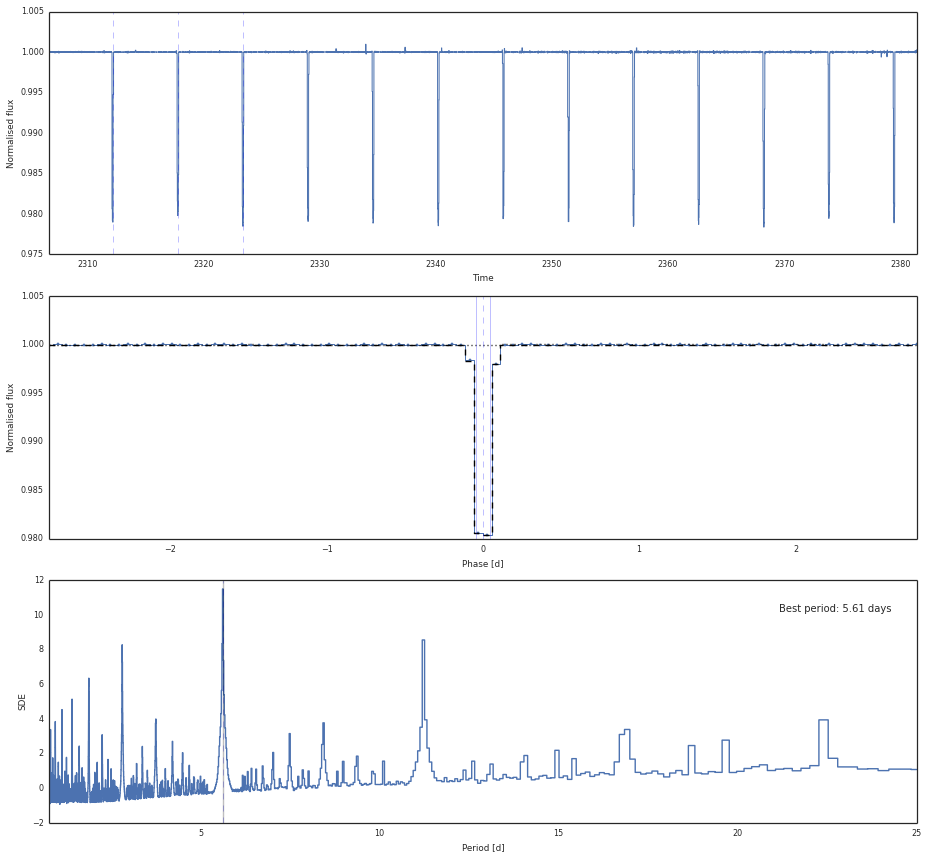

In [9]:
fid = 25
ts = TransitSearch(files[fid])
ts()
results[fid] = ts.result

rf = '../../../../analysis/k2_05/injection_tests/data/raw/ktwo{:9d}-c05_llc.fits'.format(ts.epic)
head = pf.getheader(rf,1)

print ts._rbls['bls_period'], head['inj_per'], head['inj_k'], head['inj_k']**2, '\n'

fig,ax = subplots(3,1,figsize=(13,12))
ts.plot_lc_time(ax[0])
ts.plot_lc(ax[1], 100)
ts.plot_sde(ax[2])
ax[2].axvline(head['inj_per'], alpha=0.25, c='k')
fig.tight_layout()

r = rarr(ts.result)
print 'lnlike 0: {:10.2f}'.format(float(r.lnlike_constant))
print 'lnlike 1: {:10.2f}'.format(float(r.lnlike_transit))
print 'lnlike 2: {:10.2f}'.format(float(r.lnlike_sine))
print 'lnlike 3: {:10.2f}'.format(float(r.lnlike_oe))

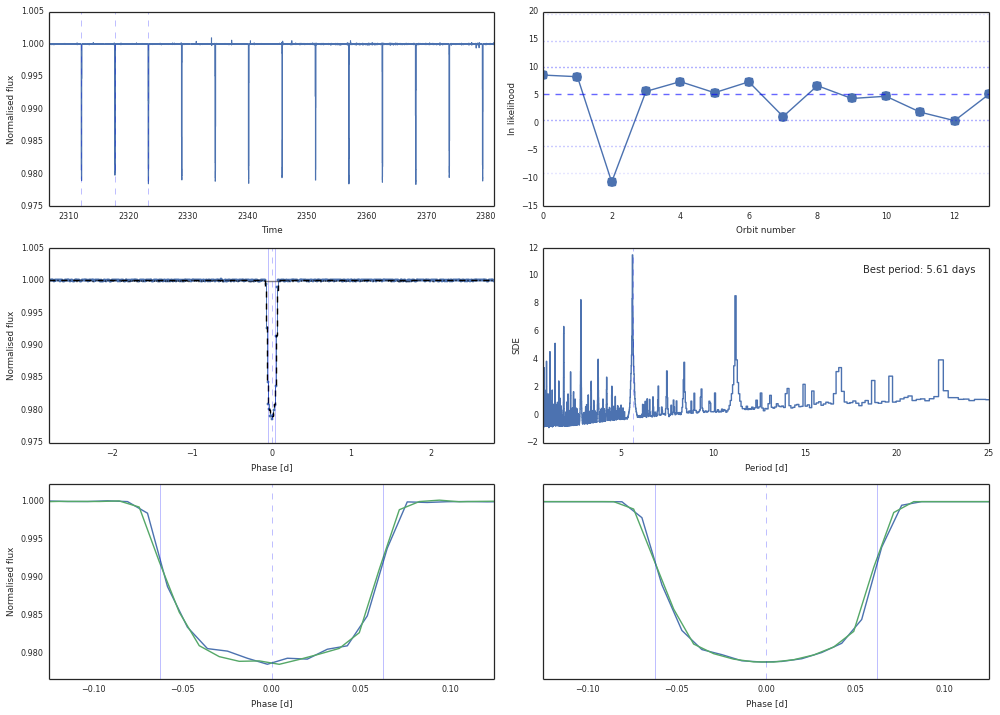

In [10]:
pmode = 'v'
pmode = 'h'

if pmode == 'v':
    fig = figure(figsize=(13,14))
    gs = GridSpec(5,2)
    ax_lctime = subplot(gs[0,:])
    ax_lcfold = subplot(gs[1,:])
    ax_lnlike = subplot(gs[3,:])
    ax_lcoe   = subplot(gs[2,0]),subplot(gs[2,1])
    ax_sde    = subplot(gs[4,:])
elif pmode == 'h':
    fig = figure(figsize=(14,10))
    gs = GridSpec(3,4)
    ax_lctime = subplot(gs[0,:2])
    ax_lcfold = subplot(gs[1,:2])
    ax_lnlike = subplot(gs[0,2:])
    ax_sde    = subplot(gs[1,2:])
    ax_lcoe   = subplot(gs[2,:2]),subplot(gs[2,2:])
    
ts.plot_lc_time(ax_lctime)
ts.plot_lc(ax_lcfold)
ts.plot_even_odd_lc(ax_lcoe)
ts.plot_lnlike(ax_lnlike)
ts.plot_sde(ax_sde)

fig.tight_layout()

In [12]:
for fid in range(120):
    ts = TransitSearch(files[fid])
    ts()
    results[fid] = ts.result
    if fid < 100:
        results[fid]['type'] = 'Planet' if Y[fid] == 1 else 'Trash'
    clear_output()
    display(fid)

0

KeyboardInterrupt: 

In [17]:
rfull = hstack(results.values())

In [18]:
rfull['type'][array(Y, np.bool)] = 'Planet'
rfull['type'][~array(Y, np.bool)] = 'Trash'

In [19]:
df_full = pd.DataFrame(rfull)

In [20]:
def BIC(lnlike, npar, npt):
    return -2*lnlike + npar*log(npt)

In [27]:
def create_input_df(df):
    tf = df.loc[:,'flux_std sde ntr trf_period trf_duration trf_radius_ratio '
                'trf_semi_major_axis trf_impact_parameter oe_diff_k po_lnlike_max po_lnlike_min'.split()]
    tf['log10_fm'] = log10(df.flux_median).replace(nan,0)
    tf['sin_amp'] = df.sine_amplitude
    tf['bic_c'] = BIC(df_full.lnlike_constant, 0, ts.flux.size)
    tf['bic_diff_tc'] = BIC(df_full.lnlike_transit,  5, ts.flux.size) - tf.bic_c
    tf['bic_diff_vc'] = BIC(df_full.lnlike_sine,     1, ts.flux.size) - tf.bic_c
    tf = tf.rename(columns=dict(bls_ntr = 'ntr', trf_period = 'period', trf_duration = 'T14', bls_sde='sde',
                          trf_radius_ratio='k', trf_semi_major_axis='a', trf_impact_parameter='b'))
    tf = tf.replace(nan, 0)
    return tf

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

In [29]:
df_train = create_input_df(df_full[:100])
df_test  = create_input_df(df_full[100:])

In [30]:
X = df_train.values
Y = df_full.type[:100]
clf = RandomForestClassifier(n_estimators=100)
clf = clf.fit(X, Y)

print clf.feature_importances_
print clf.predict_proba(df_test.values)
print clf.predict(df_test.values)

[ 0.05757072  0.29125758  0.01711065  0.03526298  0.04222306  0.03195613
  0.08079158  0.00869745  0.0588237   0.01434334  0.01277863  0.06232768
  0.01335139  0.02204163  0.12524135  0.12622213]
[[ 0.99  0.01]
 [ 0.47  0.53]
 [ 0.91  0.09]
 [ 0.64  0.36]
 [ 0.19  0.81]
 [ 1.    0.  ]
 [ 0.74  0.26]
 [ 0.07  0.93]
 [ 1.    0.  ]
 [ 0.99  0.01]
 [ 0.7   0.3 ]
 [ 0.41  0.59]
 [ 0.31  0.69]
 [ 0.07  0.93]
 [ 0.73  0.27]
 [ 0.98  0.02]
 [ 0.22  0.78]
 [ 0.63  0.37]
 [ 0.88  0.12]
 [ 0.13  0.87]]
['Planet' 'Trash' 'Planet' 'Planet' 'Trash' 'Planet' 'Planet' 'Trash'
 'Planet' 'Planet' 'Planet' 'Trash' 'Trash' 'Trash' 'Planet' 'Planet'
 'Trash' 'Planet' 'Planet' 'Trash']


In [32]:
scores = cross_val_score(clf, X, Y, cv=20)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.93 (+/- 0.19)


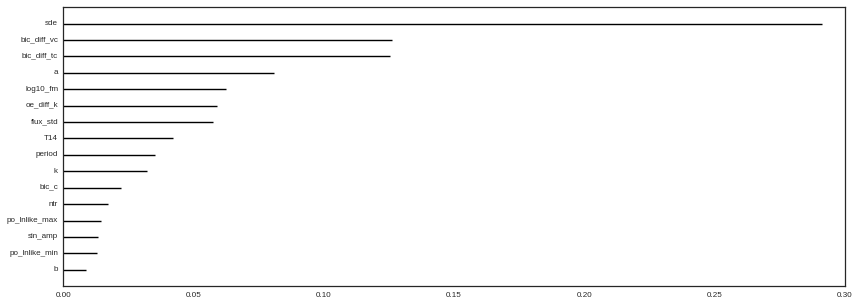

In [33]:
fsid = argsort(clf.feature_importances_)
hlines(range(clf.n_features_), 0, clf.feature_importances_[fsid])
ylim(-1,clf.n_features_)
yticks(range(clf.n_features_), df_train.columns[fsid]);

In [196]:
pr_transit = clf.predict_proba(df_test.values)[:,1]
tids = argsort(pr_transit)[::-1]
pr_transit[tids]
print arange(100,120)[tids]

[113 107 119 116 104 112 101 111 103 117 110 106 114 118 102 115 109 105
 108 100]


(0, 1688)

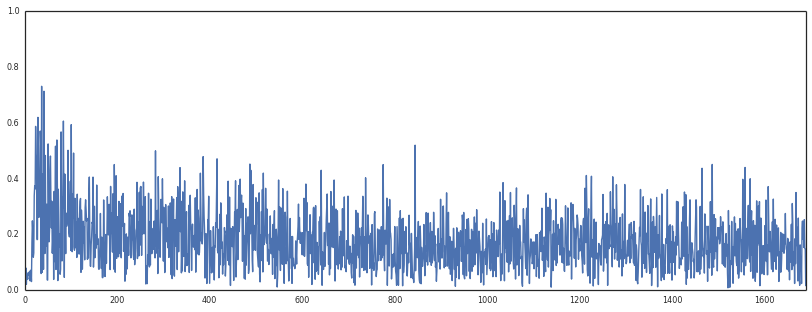

In [213]:
plot(abs(fft.fft(ts.flux)))
ylim(0,1)
xlim(0,ts.flux.size//2)